<a href="https://colab.research.google.com/github/hyunjaec/MScA_Deep_Learning_Project/blob/main/zoning_satellite_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import ndimage, signal as sg
from skimage import data, filters, io, color
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
from google.colab.patches import cv2_imshow
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization, Input, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
!pwd

/content


In [3]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#label csv
austin_df = pd.read_csv("/content/drive/My Drive/data/data/austin.csv")
austin_df = austin_df.drop('Unnamed: 0', axis = 1)
austin_df.head()

,image_name,zoning_id,zoning_zty
0,data/austin_0.jpg,229791,PUD
1,data/austin_1.jpg,229791,PUD
2,data/austin_2.jpg,400523442,I-RR
3,data/austin_3.jpg,229791,PUD
4,data/austin_4.jpg,229791,PUD


In [5]:
residential = ['LA',
            'RR',
            'SF-1',
            'SF-2',
            'SF-3',
            'SF-4A',
            'SF-4-A,'
            'SF-4B',
            'SF-5',
            'SF-6',
            'MF-1',
            'MF-2',
            'MF-3',
            'MF-4',
            'MF-5',
            'MF-6',
            'MF-CO',
            'MH']

commercial = ['NO',
            'LO',
            'GO',
            'CR',
            'LR',
            'GR',
            'L',
            'CBD',
            'DMU',
            'W/LO',
            'CS',
            'CS-1',
            'CH']

industrial = ['IP', 'LI', 'MI', 'R&D']

special = ['DR', 'AV', 'AG', 'P', 'PUD', 'TN', 'ERC', 'UNZ']

In [6]:
#loop through list of zone codes, map specific zone codes to R, C, I, or S
austin_df.loc[:, 'zone'] = np.nan

for i in residential:
    austin_df.loc[:, 'zone'] = np.where(austin_df.loc[:, 'zoning_zty'].str.contains(i) == True, 
                                     'R', austin_df.loc[:,'zone'])
for i in industrial:
    austin_df.loc[:, 'zone'] = np.where(((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & (austin_df.loc[:, 'zone'] != 'R')), 
                                     'I', austin_df.loc[:,'zone'])
for i in commercial:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'R') & (austin_df.loc[:, 'zone'] != 'I'), 
                                     'C', austin_df.loc[:,'zone'])
for i in special:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'I') & (austin_df.loc[:, 'zone'] != 'R') &\
                                     (austin_df.loc[:, 'zone'] != 'C'), 
                                     'S', austin_df.loc[:,'zone'])

In [7]:
#manually set this one
austin_df.loc[303, 'zone'] = 'R'

In [8]:
austin_df.head()

,image_name,zoning_id,zoning_zty,zone
0,data/austin_0.jpg,229791,PUD,S
1,data/austin_1.jpg,229791,PUD,S
2,data/austin_2.jpg,400523442,I-RR,R
3,data/austin_3.jpg,229791,PUD,S
4,data/austin_4.jpg,229791,PUD,S


(array([1235.,    0.,    0., 1747.,    0.,    0.,  446.,    0.,    0.,
         239.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

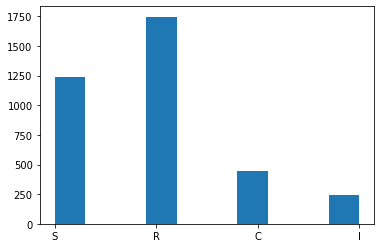

In [9]:
plt.hist(austin_df['zone'])

In [10]:
img_names = austin_df['image_name']

In [11]:
img_names = img_names

In [12]:
img_df = []
for i,j in enumerate(img_names):
  if i % 100 == 0:
    print(i)
  if i <= 100:
    img_df.append(cv2.imread("/content/drive/MyDrive/data/" + str(j[:-4])+".jpg"))
  else:
    break

0
100


In [13]:
dim = (500, 500)

In [14]:
from collections import Counter

Counter([i.shape for i in img_df])

Counter({(959, 773, 3): 4, (960, 773, 3): 97})

In [15]:
scale_percent = 60 # percent of original size
width = int(961 * scale_percent / 100)
height = int(773 * scale_percent / 100)
dim = (width, height)
dim

(576, 463)

In [16]:
#make images equal pixel 
for i, img in enumerate(img_df):
  img_df[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

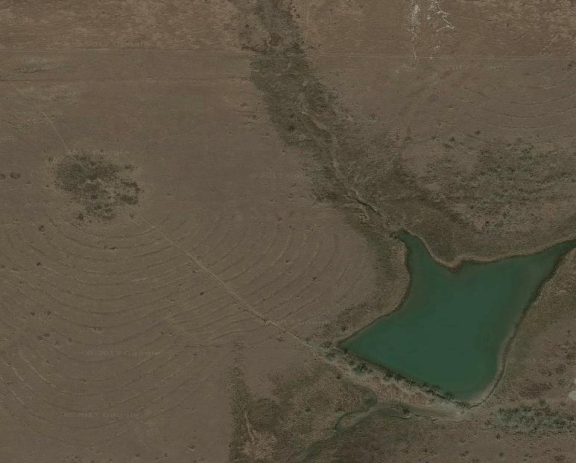

(463, 576, 3)

In [17]:
cv2_imshow(img_df[0])
img_df[0].shape

In [19]:
# fig, ax = plt.subplots(1, 4, figsize=(15, 15), sharex=True, sharey=True)
# ax1, ax2, ax3, ax4 = ax.ravel()

# ax1.imshow(img_df[53], vmin=0, vmax=255, cmap=plt.cm.gray)
# ax1.set_title('Residential')

# ax2.imshow(img_df[138], vmin=0, vmax=255, cmap=plt.cm.gray)
# ax2.set_title('Commercial')

# ax3.imshow(img_df[397], vmin=0, vmax=255, cmap=plt.cm.gray)
# ax3.set_title('Industrial')

# ax4.imshow(img_df[72], vmin=0, vmax=255, cmap=plt.cm.gray)
# ax4.set_title('Special')


# plt.show()

In [20]:
len(img_df)

101

In [21]:
img_df2 = np.array(img_df) 
zone_class = np.array(austin_df['zone'][:101]) 
zone_class = pd.get_dummies(zone_class)
#split labels and images for train&test
#X_train, X_test, y_train, y_test = train_test_split(img_df2[:1000], zone_class[:1000], test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(img_df2, zone_class, test_size=0.3)
input_shape = (dim[1], dim[0], 3)

In [22]:
X_train = X_train/255
X_test = X_test/255

In [33]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 strides = (1, 1),
                 activation='relu', 
                 input_shape=(input_shape)))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))


In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 461, 574, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 461, 574, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 230, 287, 64)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4224640)           0         
                                                                 
 dense_6 (Dense)             (None, 10)                42246410  
                                                                 
 dropout_3 (Dropout)         (None, 10)               

In [35]:
model.compile(optimizer= tf.keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [36]:
batch_size = 32
epochs = 50

In [37]:
history = model.fit(x=X_train, y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Epoch 1/50
3/3 [==============================] - 21s 5s/step - loss: 1.3084 - accuracy: 0.3571 - val_loss: 1.0265 - val_accuracy: 0.4839
Epoch 2/50
3/3 [==============================] - 18s 5s/step - loss: 0.9874 - accuracy: 0.4857 - val_loss: 1.1433 - val_accuracy: 0.4839
Epoch 3/50
3/3 [==============================] - 18s 5s/step - loss: 0.7156 - accuracy: 0.7429 - val_loss: 1.1882 - val_accuracy: 0.1935
Epoch 4/50
3/3 [==============================] - 18s 5s/step - loss: 0.6065 - accuracy: 0.8000 - val_loss: 1.0679 - val_accuracy: 0.4839
Epoch 5/50
3/3 [==============================] - 19s 5s/step - loss: 0.5202 - accuracy: 0.7857 - val_loss: 1.1493 - val_accuracy: 0.4516
Epoch 6/50
3/3 [==============================] - 18s 5s/step - loss: 0.4438 - accuracy: 0.9143 - val_loss: 1.1481 - val_accuracy: 0.0645
Epoch 7/50
3/3 [==============================] - 18s 5s/step - loss: 0.4326 - accuracy: 0.8429 - val_loss: 1.1072 - val_accuracy: 0.4194
Epoch 8/50
3/3 [==================

In [38]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [1.061785101890564, 0.4838709533214569]


Text(0.5, 1.0, 'Loss Curves')

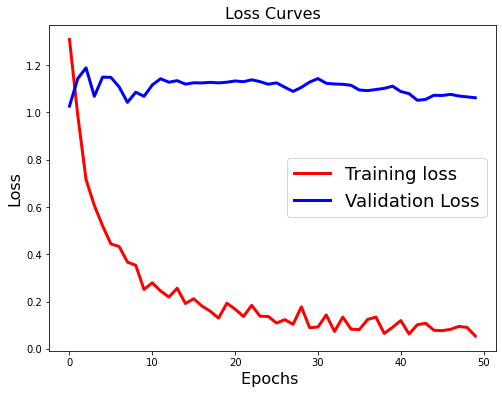

In [39]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

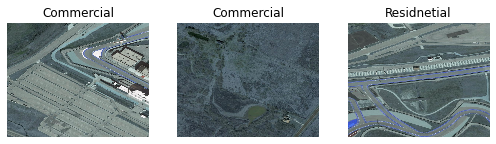

In [40]:
class_names = ['Residnetial', 'Commercial', 'Industrial','Speical']
images_and_labels = list(zip(X_test, y_test))
plt.figure(figsize=(30,30))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(4, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred= pred[0].argmax(axis=0)
    plt.title(class_names[pred])
plt.show()